##  EDA of our RGB Image Train Dataset  and UMAP Mappings

**version of umap 0.3.10, did work, but latest version 0.5.x did not find tensorflow files**

In [1]:
#import umap
import umap.umap_ as umap


In [2]:
import numpy as np
import pandas as pd
import datashader as ds
import datashader.utils as utils
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt
import seaborn as sns


**UMAP (Uniform Manifold Approximation and Projection) can be used in data pre-processing to reduce its dimensionality, which can help with visualization and potentially improve the performance of machine learning models.**



In [3]:

source_df = pd.read_csv('output_rgb.csv')



In [4]:
source_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel14390,pixel14391,pixel14392,pixel14393,pixel14394,pixel14395,pixel14396,pixel14397,pixel14398,pixel14399
0,0,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,2,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,2,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,3,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,1,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


**our dataset:**</p>
articleType</p>
Casual Shoes    1322</p>
Watches         1249</p>
Pants           1139</p>
Tshirts         1116</p>

**We take values starting at 1, because at 0, the content is not a pixel but the label:**

In [5]:

#data = source_df.iloc[:, :source_df.shape[1]].values.astype(np.float32)
data = source_df.iloc[:, 1:].values.astype(np.float32)


In [6]:
#target = source_df['class'].values
target = source_df['label'].values

In [7]:
label_key = {
    "Pants": 0, 
    "Tshirts":1,
    "Watches":2, 
    "Casual Shoes":3 
 
}

**The dictionary below is needed for coloring the clusters. An interesting visualization is to label all the test data as 5: unknown, and color map it to black. This can be optional after obtaining results.**

In [8]:
color_key = {
    "0": "#FF0000",  # Bright Red, Pants
    "1": "#00FF00",  # Bright Green, T-shirts
    "2": "#0000FF",  # Bright Blue, Watches
    "3": "#FFFF00",  # Bright Yellow, Casual Shoes

}

**A dip into UMAP theory**
UMAP, at its core, works very similarly to t-SNE - both use graph layout algorithms to arrange data in low-dimensional space. In the simplest sense, UMAP constructs a high dimensional graph representation of the data then optimizes a low-dimensional graph to be as structurally similar as possible.</p>
https://pair-code.github.io/understanding-umap/


**The mappoing below with nearest neighborhood of 30 and a 2D mapping projection, is the result of exploring various hyperparameter ssettings, as showcased futher below.** 

The color was added to vis the mapping. We can clearly see the data has mapped into distinct clusters. This is an opportunity, where we can fit the transmformed test data using a classifier. A new image with an unknown label, would first be transformed by UMAP into two dimensions. Then the transformed unknown image would be provided as input to our classifer model to get a label as the output. Due to the clusters, the appropiate classifier model seems to be a K-Nearest-Neighbor model or a Label Propagation Algorithm from Neo4J. However we are not committing to any of these classifier/labeling methods. 

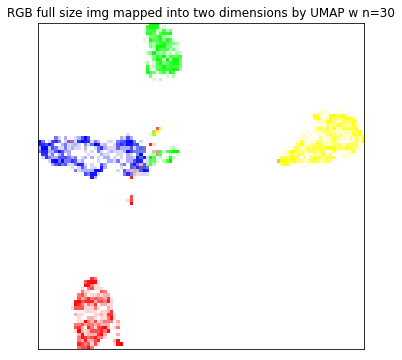

In [9]:
# Initialize UMAP
reducer = umap.UMAP(n_neighbors = 30, random_state=42)
#reducer = umap(random_state=42)


# Fit and transform the data
embedding = reducer.fit_transform(data)

# Prepare the data for visualization
df = pd.DataFrame(embedding, columns=('x', 'y'))
#df['class'] = pd.Series([str(x) for x in target], dtype="category")
df['class'] = pd.Series([str(x) for x in target], dtype="category")

# Visualize the data using datashader
#cvs = ds.Canvas(plot_width=400, plot_height=400)
cvs = ds.Canvas(plot_width=100, plot_height=100)
agg = cvs.points(df, 'x', 'y', ds.count_cat('class'))
img = tf.shade(agg, color_key=color_key, how='eq_hist')
utils.export_image(img, filename='rgb_dataset30', background='white')

# Display the image
image = plt.imread('rgb_dataset30.png')
fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(image)
plt.setp(ax, xticks=[], yticks=[])
plt.title("RGB full size img mapped into two dimensions by UMAP w n=30", fontsize=12)
plt.show()




**The team tried several nearest_neighbors values and the best one is n=30**

**Export embedding to CSV**</p>
The file below embedded_gray_data.csv has been later superseded 

**We export the new x and y coordinates for each train image. We are doing this such that we can upload the new test data at a later convenient time to train/fit our classifier model (and avoid running UMAP everytime, therefore saving time and allowing for reproducibility). UMAP is an stochastic output, therefore everytime its run, the x and y mappings are different**

In [67]:
# Ensure target is a 2D array with shape (3377, 1)
full_target = target[:, np.newaxis]

# Concatenate along the second axis
emb_target = np.concatenate((full_target, embedding), axis=1)

column_names = ['label','embedding x', 'embedding y']
embedding_df = pd.DataFrame( emb_target, columns=column_names)
embedding_df.head()

embedding_df.to_csv('umap_rgb_mapping.csv', index=False, header=True)  

In [69]:
embedding_df = pd.read_csv('umap_rgb_mapping.csv')
embedding_df.head()

,label,embedding x,embedding y
0,0.0,7.230391,9.234395
1,2.0,3.608030,-0.909678
2,2.0,3.318318,-2.557763
3,3.0,-8.564292,5.395351
4,1.0,1.058524,-11.521009


**start 3:02pm**

## More exploration, n=50,...1000

The default value of n_neighbors for UMAP (as used above) is 15, but we will look at values ranging from 2 (a very local view of the manifold) up to 1000.

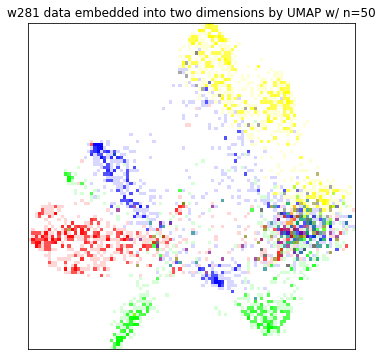

In [55]:
# Initialize UMAP
reducer = umap.UMAP(n_neighbors = 50, random_state=42)
#reducer = umap(random_state=42)


# Fit and transform the data
embedding = reducer.fit_transform(data)

# Prepare the data for visualization
df = pd.DataFrame(embedding, columns=('x', 'y'))
#df['class'] = pd.Series([str(x) for x in target], dtype="category")
df['class'] = pd.Series([str(x) for x in target], dtype="category")

# Visualize the data using datashader
cvs = ds.Canvas(plot_width=100, plot_height=100)
agg = cvs.points(df, 'x', 'y', ds.count_cat('class'))
img = tf.shade(agg, color_key=color_key, how='eq_hist')
#changed from black to white
utils.export_image(img, filename='RGB_dataset50', background='white')

# Display the image
image = plt.imread('RGB_dataset50.png')
fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(image)
plt.setp(ax, xticks=[], yticks=[])
plt.title("RGB data embedded into two dimensions by UMAP w/ n=50", fontsize=12)
plt.show()

**Here we explore mapping into 3 dimensions**

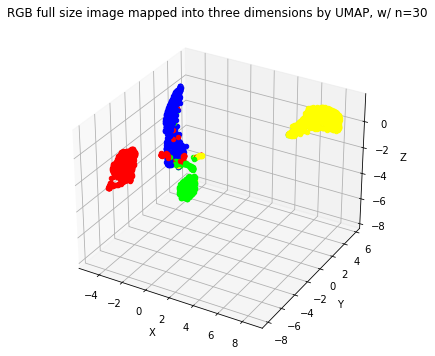

In [9]:
from mpl_toolkits.mplot3d import Axes3D

# Initialize UMAP
reducer = umap.UMAP(n_neighbors = 30, n_components=3, random_state=42)
#reducer = umap(random_state=42)


# Fit and transform the data
embedding = reducer.fit_transform(data)

# Assuming 'embedding' is your 3D data
df = pd.DataFrame(embedding, columns=('x', 'y', 'z'))
df['class'] = pd.Series([str(x) for x in target], dtype="category")

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Create a color map
colors = color_key# replace with your classes and desired colors

# Plot each point
for i in range(len(df)):
    ax.scatter(df.loc[i, 'x'], df.loc[i, 'y'], df.loc[i, 'z'], color=colors[df.loc[i, 'class']])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("RGB full size image mapped into three dimensions by UMAP, w/ n=30", fontsize=12)
plt.show()


**No additional improvement in clustering is perceived from a 3D mapping. Therefore there is no perceived justification for the additional complexity of the data. However, depending on our final results, we may decide to use a 3D mapping.**

**note:**</p>
Since my decision to map the data using UMAP is based on perceived clustering, I will not run models using hyperspace of dimenions 4 and higher, since I cannot evaluate above 3 dimensions. 

In [11]:
# Ensure target is a 2D array with shape (3377, 1)
full_target = target[:, np.newaxis]

# Concatenate along the second axis
emb_target = np.concatenate((full_target, embedding), axis=1)

column_names = ['label','embedding x', 'embedding y', 'embedding z']
embedding_df = pd.DataFrame( emb_target, columns=column_names)
embedding_df.head()

embedding_df.to_csv('umap_rgb_mapping_3d.csv', index=False, header=True)  

In [12]:
embedding_df = pd.read_csv('umap_rgb_mapping_3d.csv')
embedding_df.head()

,label,embedding x,embedding y,embedding z
0,0.0,-3.128895,-7.793591,-0.703375
1,2.0,-3.615993,0.736214,-1.270389
2,2.0,-4.616339,1.679079,-1.337356
3,3.0,8.076443,4.586558,0.303278
4,1.0,-4.336779,4.859769,-7.231673
